In [1]:
import os
import urllib.request
import requests
import csv
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from pprint import pprint
import sys
from collections import defaultdict
from dateutil import parser
import matplotlib
%matplotlib inline

## Identify one or more suitable web APIs

<span style="color:red">API Chosen:</span> https://apifootball.com/ & https://sportmonks.com/

I decided to use two different APIs which both return data on football matches. The reason why I decided to use two APIs is that these services only offer access to certain leagues when availing of the trial packages. The Apifootball API offers the English Championship league for free and the Sports Monk API offers the English premier league and the Danish league for free.

The API keys I received can be seen below:

In [2]:
apifootball_api_key = "bbef48014d349d0e2bab8173387e35cce97dc76ff335a4c7eed9969c7758f8ff"
sport_monks_api_key = 'B9BjGpZWKDeOESF7bY6f5v6GsdZgpqLjCYUtIHbPdqbaVFmxJGpNw7ozVBP2'

##  Collect data of chosen APIs

<span style="color:red">Collecting Raw Data - Functions needed:</span>

The get_raw_data() function was written to allow multiple calls of the API as only limited data is available per call. In this case each call is a month worth of data. 

The get_sports_monk_raw_data() gets data on the leagues, countries, seasons from the sports monk api and saves them as json files. The reason for this data is to help encode the fixture data from id's to strings. eg.. In the main sports_monk json returened, the league and other fields will be in a id rather the the string names. This will ensure that the whole dataframe will be readable.   

These function are commented throughout and are called In section 3:

In [3]:
# fucntion that creates a json file
def create_json_file(data, file_loc):
    with open(file_loc, 'w') as f:
        json.dump(data, f)


def get_raw_data(api_url, api_key, league_id, year, month, type_request): #month needs to be a string to avoid invalid token errors for ints as the API needs a leading 0 for single digit months
    
    #start at the first of every month
    day = "01"
    
    if month == "02": #need to change end date in the call to the API as it doesn't return full values if the date doesn't exist, e.g. 31st of February
        end_day = "28"
    elif month in ["04", "06", "09", "11"]:
        end_day = "30"
    else: 
        end_day = "31"  
    # To determine which api is being requested
    if type_request == "apifootball":
        link = api_url + str(year) +"-"+ month+"-"+ day + "&to="+ str(year) +"-"+ month+"-"+ end_day +"&league_id="+ league_id + "&APIkey=" + api_key
    elif type_request == "sports_monk_fixtures":
        link =  api_url + "fixtures/between/" + str(year) +"-"+ month+"-"+ day + "/" + str(year) +"-"+ month+"-"+ end_day + "?api_token=" + api_key
    else:
        print("Please enter a correct string")

    response = requests.get(link)
    data = response.json()
    
    return data

# function that additonal json datasets that describe the data in the main sports monk dataset. 
def get_sports_monk_raw_data(api_url, api_key):
    
    # The raw json needs to be loaded so the correct season id's can be requested. This will be required below when creating the dataframe
    sport_monk_data = json.load(open('data/sports_monk-data-raw.json'))
    seasons_list = []
    
    # Iterate through the raw json to get the season id's and then find the unique entries (set)
    for item in sport_monk_data:
        for i in item["data"]:
             seasons_list.append(str(i['season_id']))
            
    seasons_id = set(seasons_list)
    
     
    link_leagues =  api_url + "/leagues?api_token=" + api_key
    link_countries =  api_url + "/countries?api_token=" + api_key
    link_season =  api_url + "/seasons?api_token=" + api_key
    
    
    response_leagues = requests.get(link_leagues)
    data_leagues = response_leagues.json()
    response_countries = requests.get(link_countries)
    data_countries = response_countries.json()
    response_season = requests.get(link_season)
    data_season = response_season.json()
    data_teams = [] 
    
    # Request and store all data needed in json format. 
    for season_id in seasons_id:
        link_team = api_url + "/teams/season/" + season_id +"?api_token=" + api_key
        response_teams = requests.get(link_team)
        data = response_teams.json()
        data_teams.append(data)
    
    data_list = [data_leagues, data_countries, data_season, data_teams]
    raw_file_loc_list = ["sports_monk_leagues", "sports_monk_countries", "sports_monk_season", "sports_monk_teams"]
    
    for data, raw_file_loc in zip(data_list, raw_file_loc_list):
        create_json_file(data,"data/" + raw_file_loc + ".json")
        
    print("Sports Monk raw data has been created")
    
    

## Parse the collected data, and store it in an appropriate file format

<span style="color:red">Collecting Raw Data and writing raw data to JSON:</span>

Here data is requested from 2014 to the end of 2016. The data is appended to a list each month and then writen to a json file after all requests have been completed. 

In [4]:
###Set Variable get the raw data from the API and store in the File location set here
apifootball_league_id = "63"
apifootball_raw_file_loc = "data/apifootball-data-raw.json"
apifootball_api_url = "https://apifootball.com/api/?action=get_events&from="

sports_monk_api_url = "https://soccer.sportmonks.com/api/v2.0/"
sports_monk_league_id = "8"
sports_monk_raw_file_loc = "data/sports_monk-data-raw.json"


# the api only returns 1 month worth of data at a time 
# so a loop to iterate over all years and months beginning at Jan is needed
# the API needs the month in 0x format, therefore months 1-9 need to have a 0 added to the front,
# therefore the conversion between int and str was necessary here and a string is passed through to the funtion 


apifootball_appended_data = []
sports_monk_appended_data = []
year = 2014
while year <=2016:
    month = 1
    while month <= 12: 
        if month <10: 
            month = "0" + str(month)
        else:
            month = str(month)
        apifootball_data = get_raw_data(apifootball_api_url, apifootball_api_key,apifootball_league_id , year, month, "apifootball") 
        sports_monk_data = get_raw_data(sports_monk_api_url, sport_monks_api_key, sports_monk_league_id, year, month, "sports_monk_fixtures")
        # Append the requested data to a list
        apifootball_appended_data.append(apifootball_data)
        sports_monk_appended_data.append(sports_monk_data)
        month = int(month)+1
    year = year+1

# Store requested data to json    
create_json_file(apifootball_appended_data, apifootball_raw_file_loc)
create_json_file(sports_monk_appended_data, sports_monk_raw_file_loc)
print("Raw Data Collection Completed \n")

Raw Data Collection Completed 



In [5]:
# Get on data leagues, countries, seasons in Json format and save to data folder 
get_sports_monk_raw_data(sports_monk_api_url, sport_monks_api_key)

Sports Monk raw data has been created


## Load and represent the data using an appropriate data structure. Apply any pre-processing steps to clean/filter/combine the data

<span style="color:red">Parsing Raw Data::</span>

I compared both sets of raw data and found which data entries they had in common. I made sure only to parse these specific entries as to make sure there would be no large NaN areas of the concatenated Dataframe.

The raw data returned from the apifootball json contains some missing entries with errors, these entries have been excluded. The useable data is parsed from the raw data and stored in a default dictionary and is then converted into a Dataframe. 

The raw data returned from the sports monk json contained mostly entries in an id format. To make this dataset readable to to a user I parsed the additional sports monk datasets that were request above and replaced the id's with strings while parsing the raw data and saved it to a default dictionary. This was this converted into a Datafame.

Both dataframes are concatenaed into one dataframe and sorted by date.


In [6]:
def create_data_frame(data_dict):
    return pd.DataFrame(data_dict)

In [7]:
def get_apifootball_data_to_dataframe():
    apifootball_data = json.load(open('data/apifootball-data-raw.json'))

    # Find indicies in the data that contain errors and exclude them. Save new data as cleaned_data. 
    to_exclude = []
    for index, item in enumerate(apifootball_data):
        if type(item) == dict:
            to_exclude.append(index)

    cleaned_data = [element for i, element in enumerate(apifootball_data) if i not in to_exclude]

    #Create Dict to store the parsed data
    apifootball_dict = defaultdict(list)
    
    # Iterate through the cleaned/raw data and parse the required entries to a default dict. 
    for item in cleaned_data:
        for i in item:
            time = i["match_time"]
            time = time + ":00"
            #for key, value in i.items():
            apifootball_dict["Match_id"].append(i["match_id"])
            apifootball_dict["Country"].append(i["country_name"])
            apifootball_dict["League"].append(i["league_name"])
            apifootball_dict["Match_Date"].append(i["match_date"])
            apifootball_dict["Status"].append(i["match_status"])
            apifootball_dict["Time"].append(time)
            apifootball_dict["Hometeam"].append(i["match_hometeam_name"])
            apifootball_dict["Awayteam"].append(i["match_awayteam_name"])
            apifootball_dict["Hometeam_score"].append(i["match_hometeam_score"])
            apifootball_dict["Awayteam_score"].append(i["match_awayteam_score"])

    apifootball_df = create_data_frame(apifootball_dict)
    return apifootball_df

In [8]:
def get_sports_monk_data_to_dataframe():
    sports_monk_data = json.load(open('data/sports_monk-data-raw.json'))
    sports_monk_league_data = json.load(open('data/sports_monk_leagues.json'))
    sports_monk_season_data = json.load(open('data/sports_monk_season.json'))
    sports_monk_countries_data = json.load(open('data/sports_monk_countries.json'))
    sports_monk_teams_data = json.load(open('data/sports_monk_teams.json'))


    
    sports_monk_dict = defaultdict(list)
    # Lists to hold data from the league and season json files
    seasons_list = []
    league_id_list = []
    # Stores the league id and name to a dict
    league_dict = {}
    for item in sports_monk_league_data['data']:
        league_dict.update({item['id']:item['name'] })
    # Stores the team id and name to a dict
    team_dict = {}
    for item in sports_monk_teams_data:
        for i in item['data']:
            team_dict.update({i['id']: i['name']})



    # Iterates through the raw data and replaces some of the entries with strings from the above dicts. Parses the data and stores to a default dict
    for item in sports_monk_data:
        for i in item["data"]:
            # Get id's that need to be converted to strings 
            season_id = i['season_id']
            seasons_list.append(season_id)
            league_id = i["league_id"]
            league_id_list.append(league_id)
            home_team_id = i["localteam_id"]
            away_team_id = i["visitorteam_id"]
            #Parse data to default dict
            date = i["time"]["starting_at"]["date"]
            time = i["time"]["starting_at"]["time"]
            status = i["time"]["status"]
            fulltime_score = i["scores"]['ft_score']
            fulltime_score = fulltime_score.split("-")
            league_id = i["league_id"]
            sports_monk_dict["Match_id"].append(i["id"])
            sports_monk_dict["League"].append(league_dict[league_id])
            sports_monk_dict["Hometeam"].append(team_dict[home_team_id])
            sports_monk_dict["Awayteam"].append(team_dict[away_team_id])
            sports_monk_dict["Hometeam_score"].append(fulltime_score[0])
            sports_monk_dict["Awayteam_score"].append(fulltime_score[1])
            sports_monk_dict["Time"].append(time)
            sports_monk_dict["Match_Date"].append(date)
            sports_monk_dict["Status"].append(status)
            if league_id == 271:
                sports_monk_dict["Country"].append("Denmark")
            elif league_id == 501:
                sports_monk_dict["Country"].append("Scotland")


    sm_df = create_data_frame(sports_monk_dict)


    return sm_df

In [9]:
#Call the two function above and create the dataframes and then concatante them into 1 dataframe
apifoot_df = get_apifootball_data_to_dataframe()
sm_df = get_sports_monk_data_to_dataframe()
frames = [apifoot_df, sm_df]
football_df = pd.concat(frames)
# Sort data frame by date
football_df = football_df.sort_values(by=["Match_Date"]).reset_index(drop=True)
football_df.head(10)

,Awayteam,Awayteam_score,Country,Hometeam,Hometeam_score,League,Match_Date,Match_id,Status,Time
0,Partick Thistle,0,Scotland,Celtic,1,Premiership,2014-01-01,378554,FT,15:00:00
1,St. Johnstone,0,Scotland,Motherwell,4,Premiership,2014-01-01,378585,FT,15:00:00
2,Aberdeen,2,Scotland,Dundee United,1,Premiership,2014-01-01,378565,FT,15:00:00
3,Ross County,2,Scotland,Inverness CT,1,Premiership,2014-01-01,378575,FT,15:00:00
4,St. Mirren,1,Scotland,Kilmarnock,2,Premiership,2014-01-02,378597,FT,15:00:00
5,Hearts,1,Scotland,Hibernian,2,Premiership,2014-01-02,378607,FT,19:45:00
6,St. Johnstone,0,Scotland,Ross County,1,Premiership,2014-01-04,378617,FT,15:00:00
7,Hibernian,2,Scotland,Dundee United,2,Premiership,2014-01-05,378637,FT,15:00:00
8,Aberdeen,1,Scotland,Kilmarnock,0,Premiership,2014-01-05,378659,FT,15:00:00
9,Celtic,4,Scotland,St. Mirren,0,Premiership,2014-01-05,378627,FT,12:45:00


In [10]:
# Dataframe has 10 features and 2000+ rows 
football_df.shape

(2113, 10)

#### Filter Features

Some matches were abandoned or postponed so these will be removed.

In [11]:
football_df['Status']
football_df = football_df.loc[football_df['Status'] == 'FT']

Match_id and Status features don't seem to offer to much value anymore so will be removed

In [12]:
football_df = football_df.drop(football_df[['Status','Match_id']], axis=1)

<span style="color:red">Missing Data</span>

Final Pre-Processing steps are to look for missing data to see if further pre-processing is needed.

I noticed that every entry in the dataframe was stored as a string object. I converted the numerical features to floats and ints and the time to Datetime. 

In [13]:
# All entries are string object - will need to convert
football_df.dtypes.value_counts() 

object    8
dtype: int64

In [14]:
# Convert ? to NaN - Some entries contained null values in the from of a ? - To make it possible to impute these entries with pandas first they will have to converted to NaN
football_df = football_df.replace(to_replace="?", value="")


football_df['Awayteam_score'] = pd.to_numeric(football_df['Awayteam_score'])
football_df['Hometeam_score'] = pd.to_numeric(football_df['Hometeam_score'])

In [15]:
# Now both features are float dtype 
football_df.dtypes.value_counts() 

object    6
int64     2
dtype: int64

In [16]:
football_df.isnull().sum()

Awayteam          0
Awayteam_score    0
Country           0
Hometeam          0
Hometeam_score    0
League            0
Match_Date        0
Time              0
dtype: int64

In [17]:
# Convert date in string fromat to datetime 
football_df['Match_Date'] = pd.to_datetime(football_df['Match_Date'])
# Set index to datetime 
ind = pd.DatetimeIndex(football_df['Match_Date'])
football_df.set_index(ind, inplace=True)

#### Impute the data

In [18]:
# impute missing values with the median of both coloumns 
awayteam_score_median = football_df['Awayteam_score'].median()
hometeam_score_median = football_df['Hometeam_score'].median()

football_df['Awayteam_score'] = football_df['Awayteam_score'].fillna(awayteam_score_median)
football_df['Hometeam_score'] = football_df['Hometeam_score'].fillna(hometeam_score_median)

In [19]:
football_df.isnull().sum()

Awayteam          0
Awayteam_score    0
Country           0
Hometeam          0
Hometeam_score    0
League            0
Match_Date        0
Time              0
dtype: int64

#### Feature creation 

Here I created some additional features to help with the data exploration below. 

I created a year, month and day colour as to help with visualising and exploring the data. 
The same goes for the result, total goals columns also created. I applied one hot encoding on the results column to get total aggregate of wins, draws and losses in the data exploration section. 

I noticed that the Season in Denmark starts at a different time to the Scottish premiership and English championship( which start and finish at the same time). To avoid issues comparing the different leagues I decided to remove the Danish league and just explore the Scottish premiership and English championship.

I also noticed that some of the entries for the 2014 season were missing for the English Championship, so I decided to reduce the data to just 1 season of football for each league (2015-2016).


In [20]:
# Create columns for year, month and day - This is done to make visulising easier below 

football_df['year'] = pd.DatetimeIndex(football_df['Match_Date']).year
football_df['month'] = pd.DatetimeIndex(football_df['Match_Date']).month
football_df['day'] = pd.DatetimeIndex(football_df['Match_Date']).weekday

In [21]:
# Creating a result column
football_df['result'] = 'draw'
football_df.loc[football_df['Hometeam_score'] > football_df['Awayteam_score'], 'result'] = 'home'
football_df.loc[football_df['Awayteam_score'] > football_df['Hometeam_score'], 'result'] = 'away'


In [22]:
# convert result column to one hot enconding 
dummy = pd.get_dummies( data=football_df['result'])
football_df = pd.concat([football_df, dummy], axis=1)



In [23]:
# Creating a total goals column 
football_df['Total_goals'] = football_df['Awayteam_score'] + football_df['Hometeam_score']

In [24]:
# Remove denmark from the dataset
football_df = football_df[football_df.Country != 'Denmark']
# Create specific dataframes for each league
scottish_prem_df = football_df.loc[football_df['League'] == 'Premiership']
english_champ_df = football_df.loc[football_df['League'] == 'Championship']
# Dataframe containing the english championship and scotish premership
champ_and_prem_df = football_df


In [25]:
# Get a dataframe for for each league of the 2015-2016 seasons and a combination of both

champ_and_prem_2015_2016_df = champ_and_prem_df.loc[(champ_and_prem_df['Match_Date'] > '2015-8-1') & (champ_and_prem_df['Match_Date'] <= '2016-5-10')] 
scottish_prem_2015_2016_df = scottish_prem_df.loc[(scottish_prem_df['Match_Date'] > '2015-8-1') & (scottish_prem_df['Match_Date'] <= '2016-5-10')]
english_champ_2015_2016_df = english_champ_df.loc[(english_champ_df['Match_Date'] > '2015-8-1') & (english_champ_df['Match_Date'] <= '2016-5-10')] 


##  Analyse and summarise the cleaned dataset

<span style="color:red">***Descriptive Statistics***</span>

Initially of the Data Set containing 2015-2016 season data:



In [26]:
# The championship has double the number of teams as the scottish premership
champ_and_prem_2015_2016_df.groupby('League')['Hometeam'].nunique()

League
Championship    24
Premiership     12
Name: Hometeam, dtype: int64

In [27]:
print(" Descriptive Stats of the Scottish prem and English champ:\n")
champ_and_prem_2015_2016_df[['Awayteam_score','Hometeam_score','away','draw','home','Total_goals']].describe()

 Descriptive Stats of the Scottish prem and English champ:



,Awayteam_score,Hometeam_score,away,draw,home,Total_goals
count,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000
mean,1.142670,1.391361,0.299738,0.287958,0.412304,2.534031
std,1.079688,1.194122,0.458443,0.453108,0.492572,1.554647
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000
75%,2.000000,2.000000,1.000000,1.000000,1.000000,3.000000
max,5.000000,8.000000,1.000000,1.000000,1.000000,9.000000


In [28]:
print("Descriptive Stats of the English champ:\n")
english_champ_2015_2016_df[['Awayteam_score','Hometeam_score','away','draw','home','Total_goals']].describe()

Descriptive Stats of the English champ:



,Awayteam_score,Hometeam_score,away,draw,home,Total_goals
count,551.00000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,1.07078,1.348457,0.277677,0.312160,0.410163,2.419238
std,1.03242,1.140252,0.448260,0.463796,0.492310,1.485785
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,1.00000,1.000000,0.000000,0.000000,0.000000,2.000000
75%,2.00000,2.000000,1.000000,1.000000,1.000000,3.000000
max,5.00000,6.000000,1.000000,1.000000,1.000000,7.000000


In [29]:
print("Descriptive Stats of the Scottish prem:\n")
scottish_prem_2015_2016_df[['Awayteam_score','Hometeam_score','away','draw','home','Total_goals']].describe()

Descriptive Stats of the Scottish prem:



,Awayteam_score,Hometeam_score,away,draw,home,Total_goals
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,1.328638,1.502347,0.356808,0.225352,0.417840,2.830986
std,1.175608,1.319750,0.480186,0.418798,0.494365,1.687797
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000
75%,2.000000,2.000000,1.000000,0.000000,1.000000,4.000000
max,5.000000,8.000000,1.000000,1.000000,1.000000,9.000000


As can be seen from comparing both descriptive stats, the Scottish Prem home team score and away team score has a larger mean and standard deviation then the English championship. Due to this the Total_goals from the Scottish league has a greater mean and std also. The English Championship has double the number of games as the Scottish Prem. 



#### Data tables

In [30]:
# We can see that the home team wins the most
champ_and_prem_2015_2016_df.groupby('result')['result'].count()

result
away    229
draw    220
home    315
Name: result, dtype: int64

In [31]:
# Total sum of each month and each league
df_sum = champ_and_prem_2015_2016_df.groupby("League").resample('M').sum()
df_sum.drop(df_sum[['year','month','day']], axis=1)

Awayteam_score  Hometeam_score  away  draw  home  \
League       Match_Date                                                     
Championship 2015-08-31              69              72    17    24    18   
             2015-09-30              60              73    16    14    19   
             2015-10-31              57              76    16    19    25   
             2015-11-30              48              60    10    16    22   
             2015-12-31              67             107    16    20    35   
             2016-01-31              62              72    17    15    21   
             2016-02-29              59              76    17    18    27   
             2016-03-31              48              66    14    13    23   
             2016-04-30             102             122    26    29    30   
             2016-05-31              18              19     4     4     6   
Premiership  2015-08-31              42              49    10     7    14   
             2015-09-30              19              33     4     4    11   
             2015-10-31              32              32    11     5     8   
             2015-11-30              28              27     6     6     6   
             2015-12-31              38              38     9     6     9   
             2016-01-31              26              43     5     6     9   
             2016-02-29              24              31     5     5    12   
             2016-03-31              27              17    12     3     6   
             2016-04-30              32              38    10     4    12   
             2016-05-31              15              12     4     2     2   

                         Total_goals  
League       Match_Date               
Championship 2015-08-31          141  
             2015-09-30          133  
             2015-10-31          133  
             2015-11-30          108  
             2015-12-31          174  
             2016-01-31          134  
             2016-02-29          135  
             2016-03-31          114  
             2016-04-30          224  
             2016-05-31           37  
Premiership  2015-08-31           91  
             2015-09-30           52  
             2015-10-31           64  
             2015-11-30           55  
             2015-12-31           76  
             2016-01-31           69  
             2016-02-29           55  
             2016-03-31           44  
             2016-04-30           70  
             2016-05-31           27

In [32]:
# Mean value of each month and each league
df_mean = champ_and_prem_2015_2016_df.groupby("League").resample('M').mean()
df_mean.drop(df_mean[['year','month','day']], axis=1)

Awayteam_score  Hometeam_score      away      draw  \
League       Match_Date                                                       
Championship 2015-08-31        1.169492        1.220339  0.288136  0.406780   
             2015-09-30        1.224490        1.489796  0.326531  0.285714   
             2015-10-31        0.950000        1.266667  0.266667  0.316667   
             2015-11-30        1.000000        1.250000  0.208333  0.333333   
             2015-12-31        0.943662        1.507042  0.225352  0.281690   
             2016-01-31        1.169811        1.358491  0.320755  0.283019   
             2016-02-29        0.951613        1.225806  0.274194  0.290323   
             2016-03-31        0.960000        1.320000  0.280000  0.260000   
             2016-04-30        1.200000        1.435294  0.305882  0.341176   
             2016-05-31        1.285714        1.357143  0.285714  0.285714   
Premiership  2015-08-31        1.354839        1.580645  0.322581  0.225806   
             2015-09-30        1.000000        1.736842  0.210526  0.210526   
             2015-10-31        1.333333        1.333333  0.458333  0.208333   
             2015-11-30        1.555556        1.500000  0.333333  0.333333   
             2015-12-31        1.583333        1.583333  0.375000  0.250000   
             2016-01-31        1.300000        2.150000  0.250000  0.300000   
             2016-02-29        1.090909        1.409091  0.227273  0.227273   
             2016-03-31        1.285714        0.809524  0.571429  0.142857   
             2016-04-30        1.230769        1.461538  0.384615  0.153846   
             2016-05-31        1.875000        1.500000  0.500000  0.250000   

                             home  Total_goals  
League       Match_Date                         
Championship 2015-08-31  0.305085     2.389831  
             2015-09-30  0.387755     2.714286  
             2015-10-31  0.416667     2.216667  
             2015-11-30  0.458333     2.250000  
             2015-12-31  0.492958     2.450704  
             2016-01-31  0.396226     2.528302  
             2016-02-29  0.435484     2.177419  
             2016-03-31  0.460000     2.280000  
             2016-04-30  0.352941     2.635294  
             2016-05-31  0.428571     2.642857  
Premiership  2015-08-31  0.451613     2.935484  
             2015-09-30  0.578947     2.736842  
             2015-10-31  0.333333     2.666667  
             2015-11-30  0.333333     3.055556  
             2015-12-31  0.375000     3.166667  
             2016-01-31  0.450000     3.450000  
             2016-02-29  0.545455     2.500000  
             2016-03-31  0.285714     2.095238  
             2016-04-30  0.461538     2.692308  
             2016-05-31  0.250000     3.375000

<span style="color:red">***Seaborn and Pandas Graphing***</span>

#### Stacked Histogram

Shows the distribution of the data.

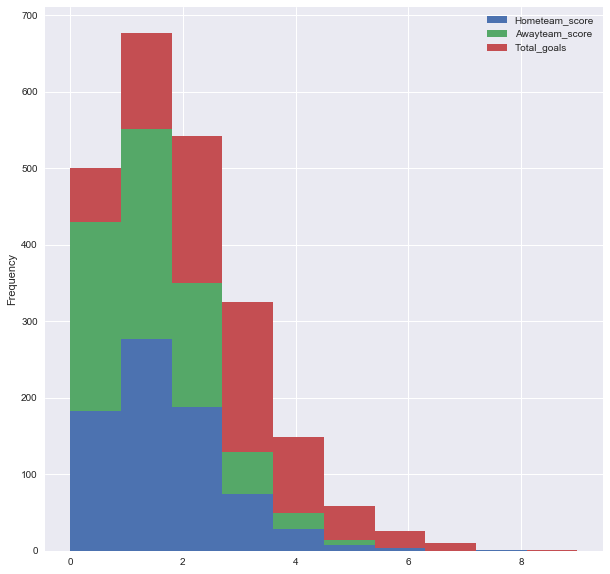

In [33]:
# Stacked histogram of the combined data
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11.7,10.27)})
champ_and_prem_2015_2016_df[['Hometeam_score', 'Awayteam_score', 'Total_goals']].plot(kind="hist",stacked=True, subplots=False, figsize=(10,10))

We can see that distribution of away team goals is larger at around 0 and 1 while Home team goals is the largest at 1 and 2.

League
Championship    AxesSubplot(0.125,0.125;0.775x0.755)
Premiership     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

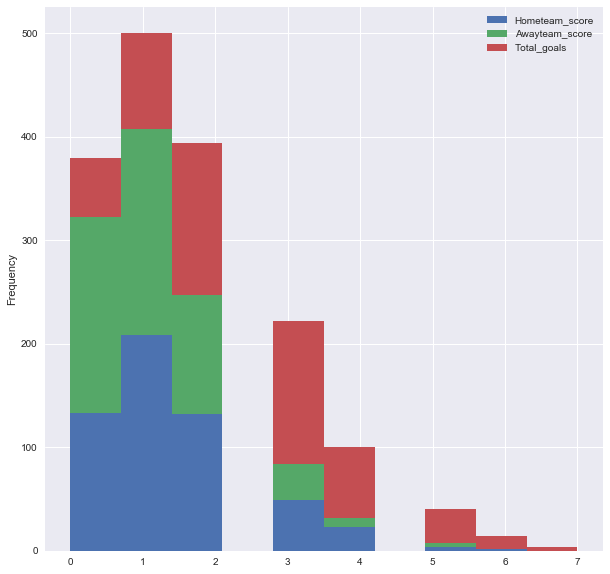

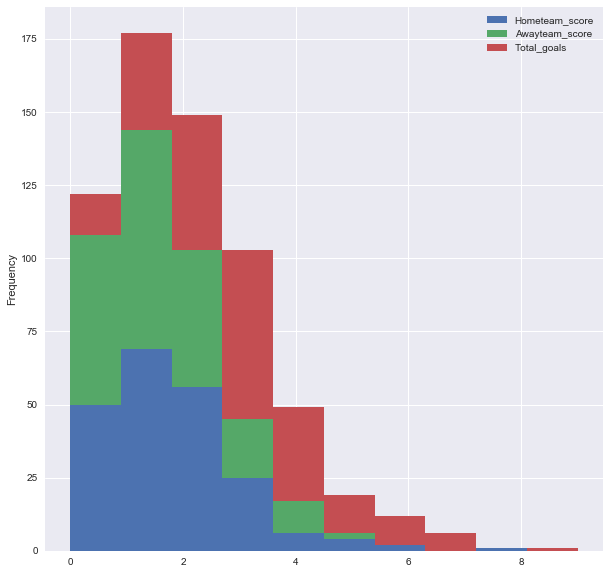

In [34]:
# Two stacked histogram, the first is the championship data and the second is the scottish data. 
champ_and_prem_2015_2016_df[['Hometeam_score', 'Awayteam_score','Total_goals','League']].groupby('League').plot(kind="hist",stacked=True, subplots=False, figsize=(10,10))

#### home/draw/away team wins 

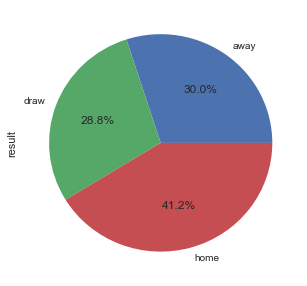

In [35]:
# Ratio of home/draw/away team wins 
champ_and_prem_2015_2016_df.groupby("result")["result"].count().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))

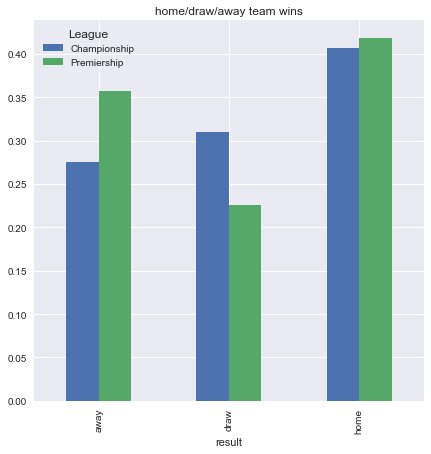

In [36]:
home_draw_away_wins = champ_and_prem_2015_2016_df.groupby(["result", "League"])["result"].count().unstack()

# Didive by amount of rows in each league to Normalise 
home_draw_away_wins['Championship'] = home_draw_away_wins['Championship'] / 556
home_draw_away_wins['Premiership'] = home_draw_away_wins['Premiership'] / 213

home_draw_away_wins.plot(kind="bar", figsize=(7,7), title="home/draw/away team wins")

We can see that the championship has more draws then the Scottish premiership but the Scottish premiership has more home wins and more away wins then the English Championship

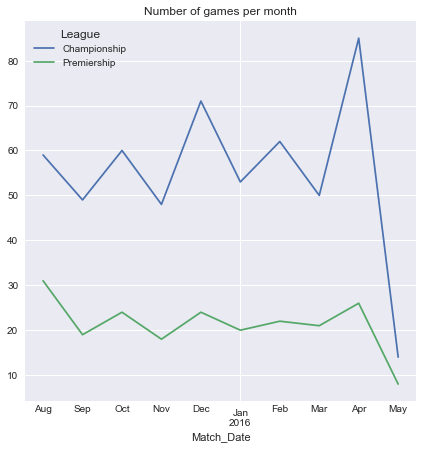

In [37]:
# Number of games per month

champ_and_prem_2015_2016_df.groupby([pd.Grouper(freq='M'), 'League']).count()['Hometeam'].unstack().plot(figsize=(7,7), title='Number of games per month')

There is a spike in games in December and at the end of the season in April. This is probably due to postponed games being rescheduled to the end of the season.

#### What day are the most average goals scored? 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


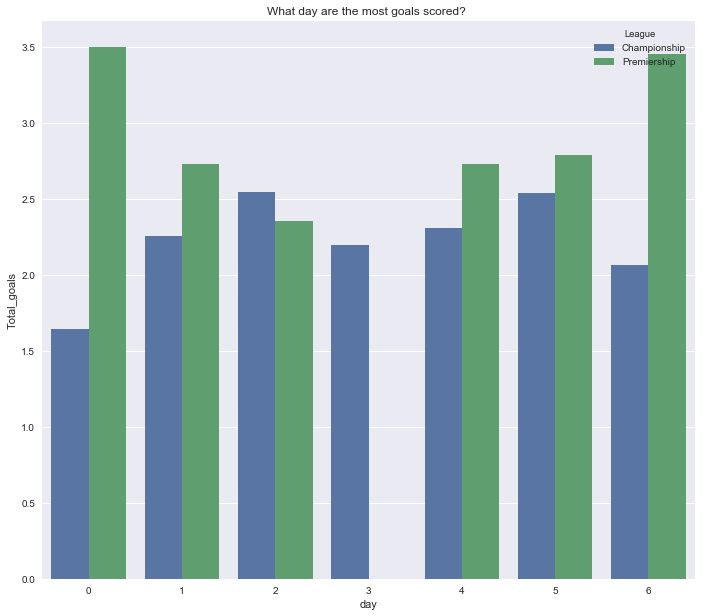

In [38]:
# What day are the most goals scored? 
day_total_goals = champ_and_prem_2015_2016_df.groupby(['day','League'])['Total_goals'].mean()
day_total_goals = day_total_goals.reset_index(level='League')
sns.barplot(x=day_total_goals.index, y="Total_goals",hue='League', data=day_total_goals).set_title('What day are the most goals scored? ');

The most goals are scored on Sundays and Mondays in the Premiership and the most goals are scored on Saturdays and Wednesday in the Championship. The least goals are scored on Mondays in the Championship and Wednesday in the Premiership.

#### What day are games played on? 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Text(0.5,1,'What day are games played on?')

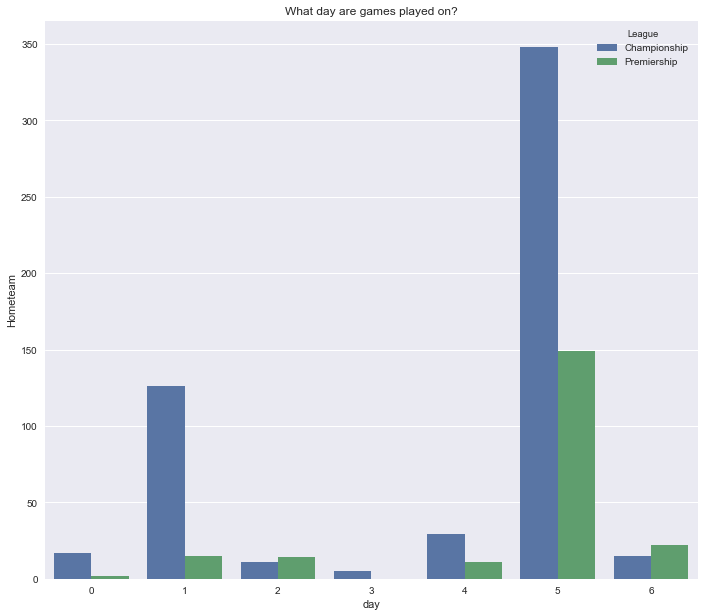

In [39]:
# What day are games played on? 
# 0 = monday
games_per_day = champ_and_prem_2015_2016_df.groupby(['day', 'League'])['Hometeam'].count()

games_per_day = games_per_day.reset_index(level='League')

sns.barplot(x=games_per_day.index, y='Hometeam', data=games_per_day, hue='League' ).set_title('What day are games played on?')

The most games are played on Saturdays. The English premiership plays much more games on Tuesdays then the Scottish premiership this is probably due to the large amount of fixtures the Championship has compared to the Premiership. The Premiership plays more games on Sundays then the Championship

####  Avg number of goals per month

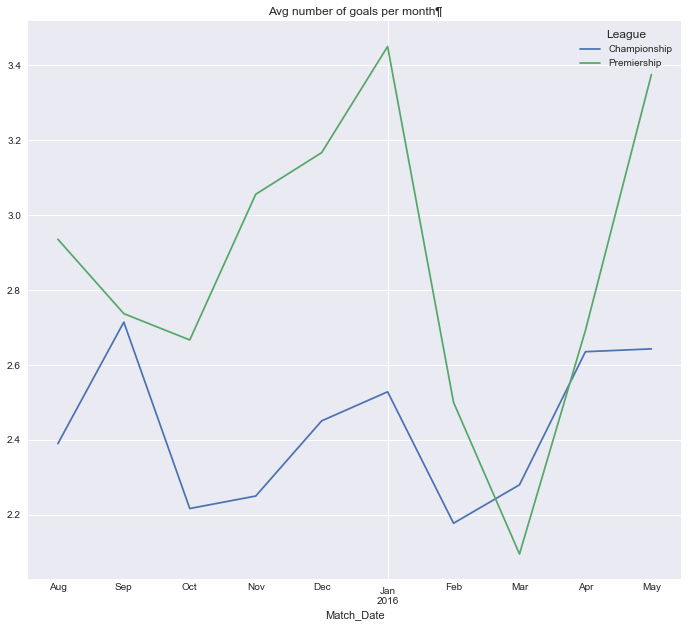

In [40]:
# Avg number of goals per month

champ_and_prem_2015_2016_df.groupby([pd.Grouper(freq='M'), 'League'])['Total_goals'].mean().unstack().plot(title='Avg number of goals per month¶')

The Scottish premiership has much more goals on average per month then the English Championship. The most goals are scored around the Christmas break where is most likley more games.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


Text(0.5,1,'Avg number of goals per month in both leagues')

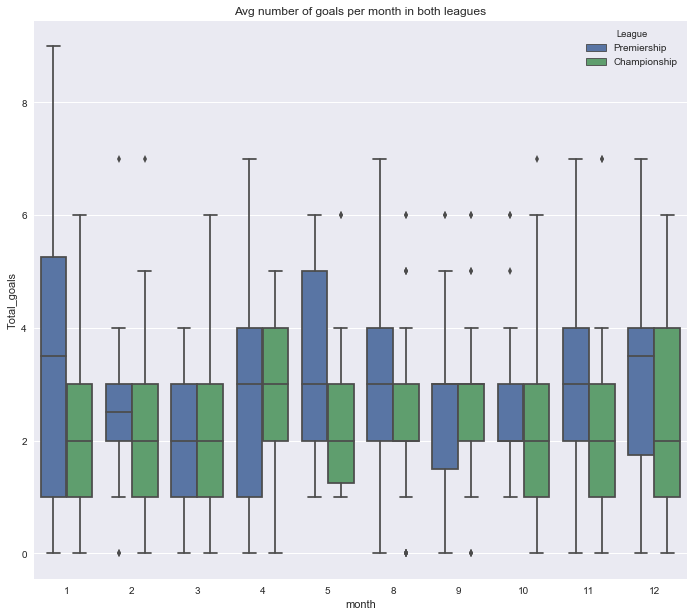

In [41]:
# Avg number of goals per month in both leagues

sns.boxplot(x='month', y='Total_goals', hue='League', data=champ_and_prem_2015_2016_df).set_title('Avg number of goals per month in both leagues')


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Text(0.5,1,'What month are the most goals scored?')

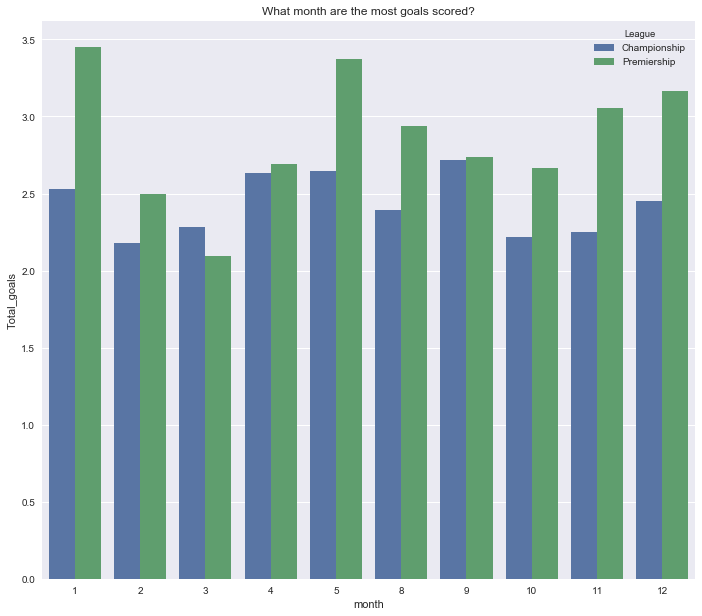

In [42]:
# What month are the most goals scored? 
month_total_goals = champ_and_prem_2015_2016_df.groupby(['month','League'])['Total_goals'].mean()
month_total_goals = month_total_goals.reset_index(level='League')
sns.barplot(x=month_total_goals.index, y="Total_goals",hue='League', data=month_total_goals).set_title('What month are the most goals scored?')

#### what kickoff times are the most goals scored? 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Text(0.5,1,'what kickoff times are the most goals scored? ')

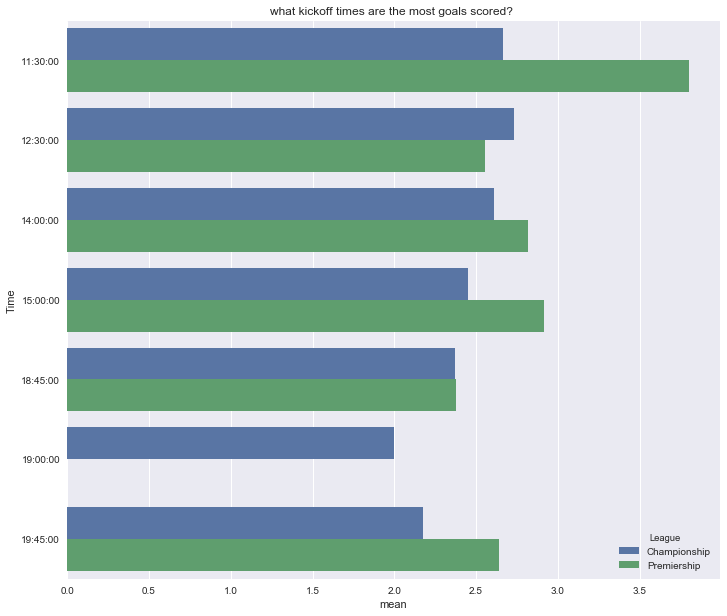

In [43]:
# what kickoff times are the most goals scored? 
time_ordered_df = champ_and_prem_2015_2016_df.sort_values(by="Time")
#sns.barplot(x='Total_goals', y='Time', hue='League', data= time_ordered_df,ci=None)
time_ordered = time_ordered_df.groupby(['Time', 'League']).agg(['mean', 'count'])
time_ordered = time_ordered.reset_index(level='League')
# get all time brackets that have more then 5 games to picking outliers
time_ordered = time_ordered.loc[(time_ordered['year']['count'] > 5)]
# plot 
sns.barplot(x=time_ordered['Total_goals']['mean'], y=time_ordered.index, hue= time_ordered['League'],ci=None).set_title('what kickoff times are the most goals scored? ')


The most goals are scored in the Premiership are are at the 11.30am kickoff and then the 03.30pm kickoff. The most goals scored in the Championship are at the 12.30am kickoff.

#### number of wins/draws/losses home & away

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017C9A7A2898>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000017C9AC97F60>], dtype=object)

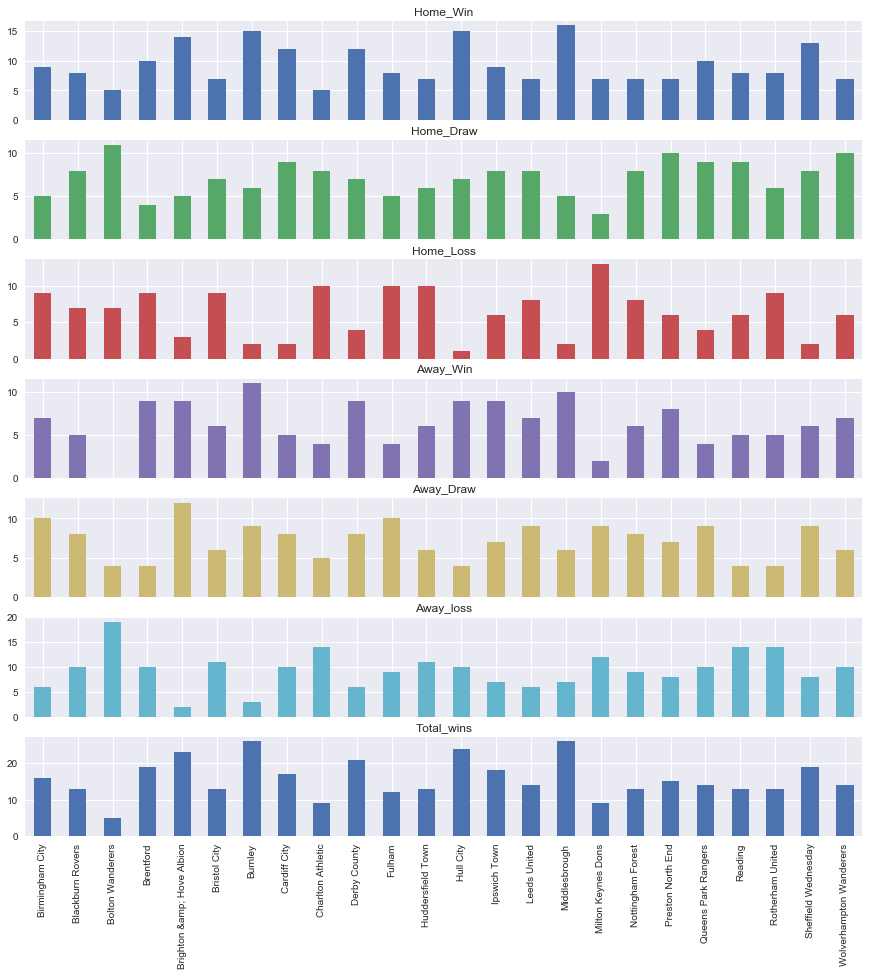

In [44]:
#number of wins/draws/losses home & away in the English Champ

#get all results for each situation 
home_wins = english_champ_2015_2016_df.groupby('Hometeam')['home'].sum()
home_draws =english_champ_2015_2016_df.groupby('Hometeam')['draw'].sum()
home_losses = english_champ_2015_2016_df.groupby('Hometeam')['away'].sum()
away_losses = english_champ_2015_2016_df.groupby('Awayteam')['home'].sum()
away_draws =english_champ_2015_2016_df.groupby('Awayteam')['draw'].sum()
away_wins = english_champ_2015_2016_df.groupby('Awayteam')['away'].sum()

tables = [home_wins, home_draws, home_losses, away_wins, away_draws, away_losses]
# combine the tables
results_eng = pd.concat(tables, axis = 1)

results_eng.columns = ['Home_Win','Home_Draw','Home_Loss', 'Away_Win', 'Away_Draw', 'Away_loss']

results_eng['Total_wins'] = results_eng['Home_Win'] + results_eng['Away_Win']

results_eng.plot(kind='bar',subplots=True,legend=False, figsize=(15,15))

Middlesbrough have the most wins with Burnley just behind them. Middlesbrough also have the most home wins with Burnley and Hull City coming second and third. Bolton Wanderers and Wolves have the most home draws. Milton keys dons had the worst home from with the most home losses. 

Burnley had the best away form with the most away wins. Brighton had the most away draws and Bolton wanderers have the worst away form with the most losses.

Overall Middlesbrough and Burnley have the highest total number of wins and Bolton wanderers have the most losses.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017C9ADEEC18>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000017C9B12A1D0>], dtype=object)

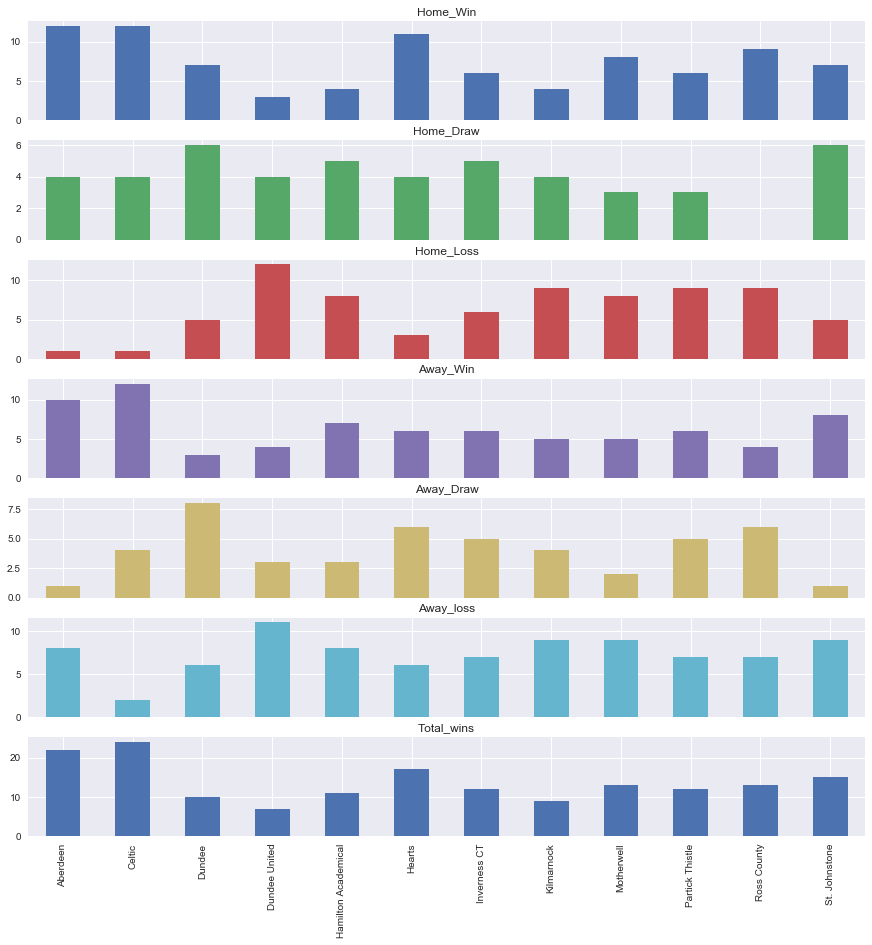

In [45]:
#number of wins/draws/losses home & away in the Scottish Premership

home_wins = scottish_prem_2015_2016_df.groupby('Hometeam')['home'].sum()
home_draws =scottish_prem_2015_2016_df.groupby('Hometeam')['draw'].sum()
home_losses = scottish_prem_2015_2016_df.groupby('Hometeam')['away'].sum()
away_losses = scottish_prem_2015_2016_df.groupby('Awayteam')['home'].sum()
away_draws =scottish_prem_2015_2016_df.groupby('Awayteam')['draw'].sum()
away_wins = scottish_prem_2015_2016_df.groupby('Awayteam')['away'].sum()

tables = [home_wins, home_draws, home_losses, away_wins, away_draws, away_losses]

results_scot = pd.concat(tables, axis = 1)

results_scot.columns = ['Home_Win','Home_Draw','Home_Loss', 'Away_Win', 'Away_Draw', 'Away_loss']

results_scot['Total_wins'] = results_scot['Home_Win'] + results_scot['Away_Win']

results_scot.plot(kind='bar',subplots=True,legend=False, figsize=(15,15))

Celtic and Aberdeen have the most home wins while Dundee united has the most losses at home. St. Johnsen and Dundee are both the draw masters with the most draws at home. Celtic have by far the best away record with the most wins followed by Aberdeen. Dundee are also the way draw masters with the most draws away. Dundee united had the worst overall form with the most away losses. 

#### League Tables

#### English Championship League Table

In [46]:
# English Championship League Table
results_eng["Win"] = results_eng['Home_Win'] + results_eng['Away_Win']
results_eng["Draw"] = results_eng['Home_Draw'] + results_eng['Away_Draw']
results_eng['Loss'] = results_eng['Home_Loss'] + results_eng['Away_loss']
eng_league_table = results_eng.iloc[:,-3:]
eng_league_table['Total_games'] = eng_league_table['Win'] + eng_league_table['Draw'] + eng_league_table['Loss']
#get total points
eng_league_table['Points'] = eng_league_table['Win']*3 + eng_league_table['Draw']
eng_league_table['Points_per_game'] = eng_league_table['Points'] / eng_league_table['Total_games']
eng_league_table = eng_league_table.sort_values(by='Points', ascending=False)
eng_league_table

,Win,Draw,Loss,Total_games,Points,Points_per_game
Burnley,26,15,5,46,93,2.021739
Middlesbrough,26,11,9,46,89,1.934783
Brighton &amp; Hove Albion,23,17,5,45,86,1.911111
Hull City,24,11,11,46,83,1.804348
Derby County,21,15,10,46,78,1.695652
Sheffield Wednesday,19,17,10,46,74,1.608696
Ipswich Town,18,15,13,46,69,1.500000
Cardiff City,17,17,12,46,68,1.478261
Brentford,19,8,19,46,65,1.413043
Birmingham City,16,15,15,46,63,1.369565


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017C9AD4ADA0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000017C9B39D860>], dtype=object)

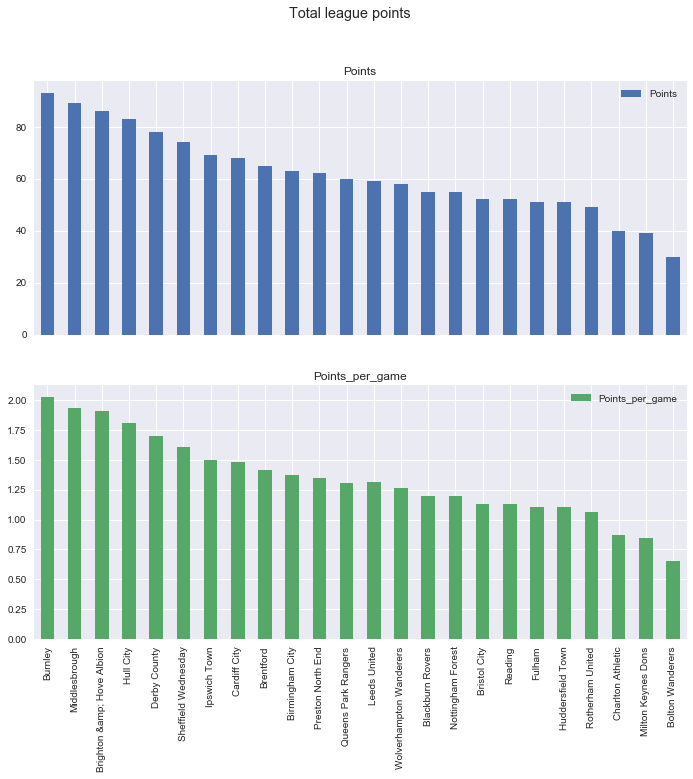

In [47]:
# Total league points
eng_league_table[['Points', 'Points_per_game']].plot(kind='bar', title='Total league points', subplots='True')

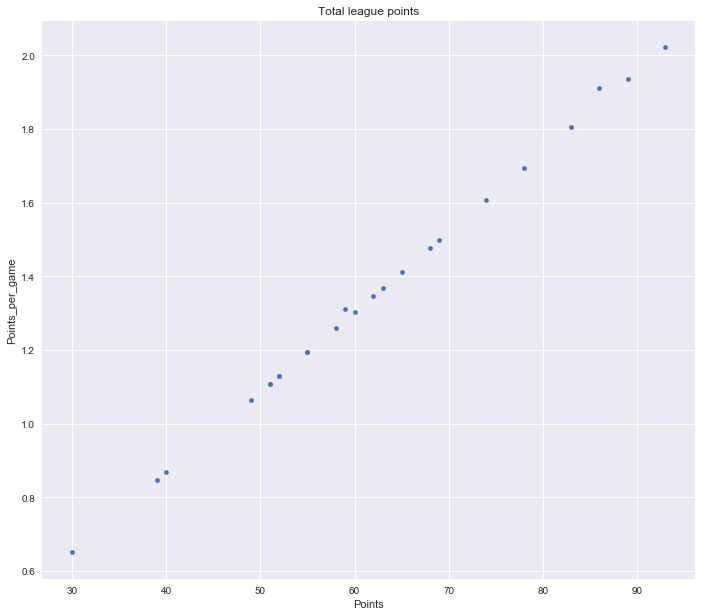

In [48]:
eng_league_table[['Points', 'Points_per_game']].plot(kind='scatter', x='Points',y='Points_per_game', title='Total league points')

We can see that Burnley were victorious in winning the league while Middlesbrough also gained automatic promotion. Charlton, MK Dons and Bolton wanderers were all relegated. It is clearly evident that there is a correlation between Total points and points per game.

#### Scottish Premiership League table

In [49]:
# Scottish Premiership League table
results_scot["Win"] = results_scot['Home_Win'] + results_scot['Away_Win']
results_scot["Draw"] = results_scot['Home_Draw'] + results_scot['Away_Draw']
results_scot['Loss'] = results_scot['Home_Loss'] + results_scot['Away_loss']
scot_league_table = results_scot.iloc[:,-3:]
scot_league_table['Total_games'] = scot_league_table['Win'] + scot_league_table['Draw'] + scot_league_table['Loss']
#get total points
scot_league_table['Points'] = scot_league_table['Win']*3 + scot_league_table['Draw']
scot_league_table['Points_per_game'] = scot_league_table['Points'] / scot_league_table['Total_games']
scot_league_table = scot_league_table.sort_values(by='Points', ascending=False)
scot_league_table

,Win,Draw,Loss,Total_games,Points,Points_per_game
Celtic,24,8,3,35,80,2.285714
Aberdeen,22,5,9,36,71,1.972222
Hearts,17,10,9,36,61,1.694444
St. Johnstone,15,7,14,36,52,1.444444
Inverness CT,12,10,13,35,46,1.314286
Ross County,13,6,16,35,45,1.285714
Dundee,10,14,11,35,44,1.257143
Motherwell,13,5,17,35,44,1.257143
Partick Thistle,12,8,16,36,44,1.222222
Hamilton Academical,11,8,16,35,41,1.171429


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017C9C8F6E80>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000017C9C946DD8>], dtype=object)

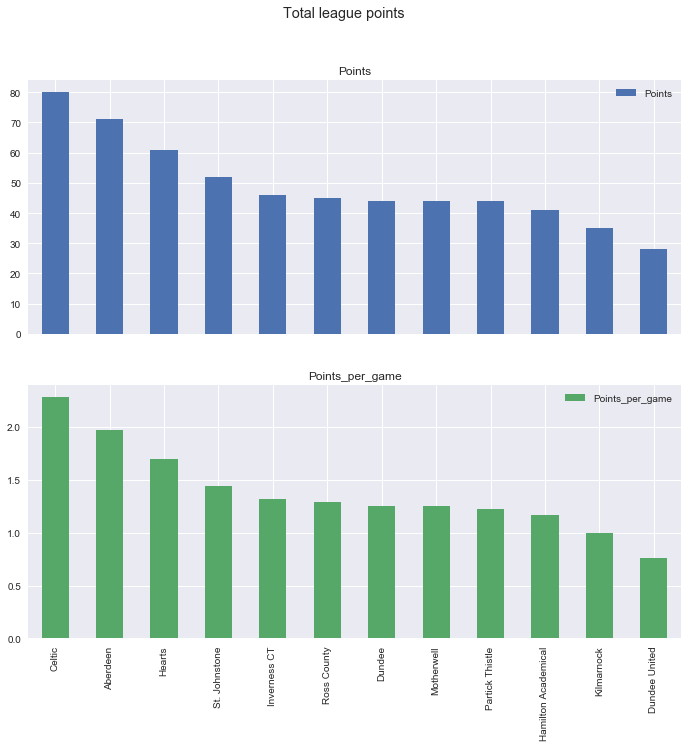

In [50]:
# Total league points
scot_league_table[['Points', 'Points_per_game']].plot(kind='bar', title='Total league points', subplots='True')

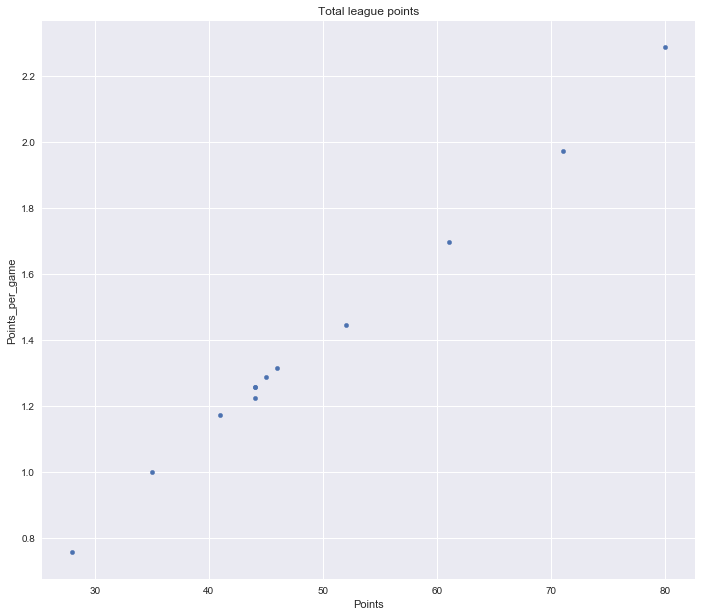

In [51]:
scot_league_table[['Points', 'Points_per_game']].plot(kind='scatter', x='Points',y='Points_per_game', title='Total league points')

We can see that Cletic were victorious in winning the league. Kilmarnock and dundee united were both relegated. It is clearly evident that there is a correlation between Total points and points per game.

#### Correlation Heat Maps

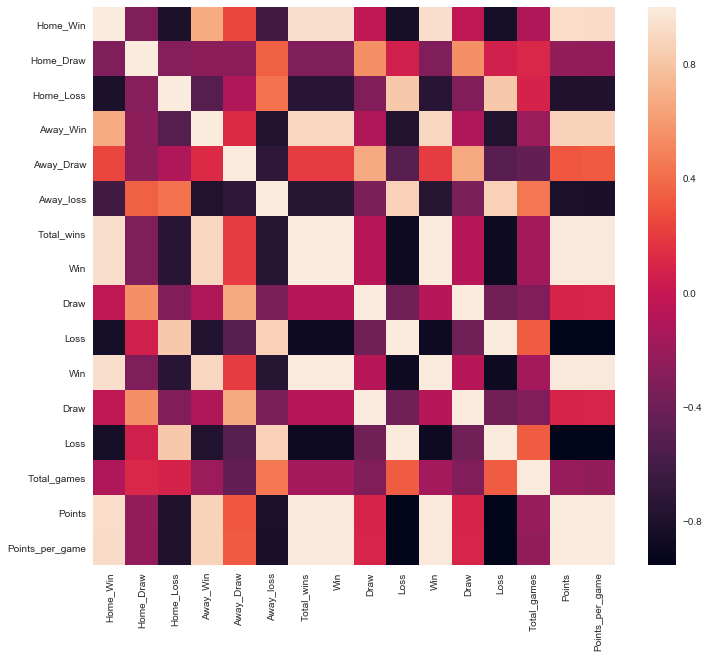

In [52]:
eng_stats = pd.concat((results_eng, eng_league_table), axis=1)

eng_stats.reset_index(inplace=True, drop = True)
# calculate the correlation matrix
corr = eng_stats.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

It is evident that Home_win and win correlates with points_per_game. While loss has a high negative correlation with points_per_game and draw is has a correlation just below -0.1.  

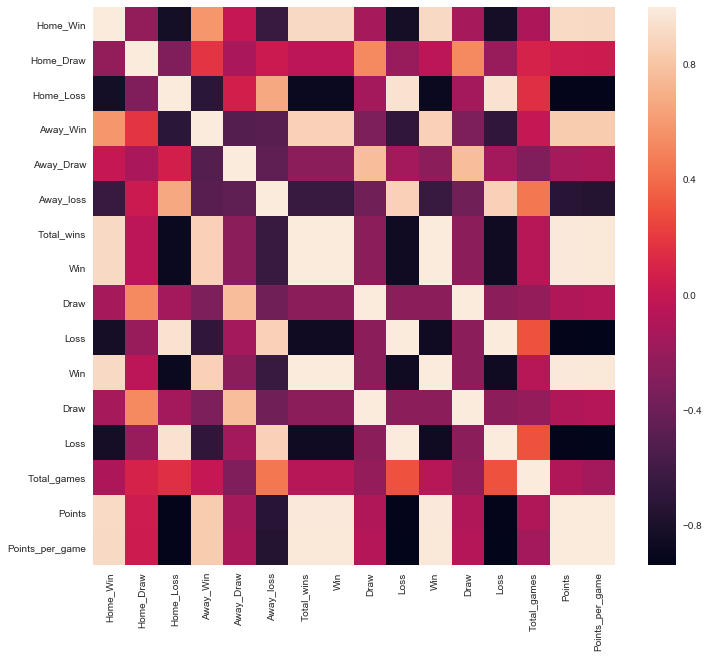

In [53]:
scot_stats = pd.concat((results_scot, scot_league_table), axis=1)

#results_eng.reset_index(drop = True, inplace = True)
# results_eng.corr(method='pearson')
scot_stats.reset_index(inplace=True, drop = True)
# calculate the correlation matrix
corr = scot_stats.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

#### Tentative Conclusion
Further in-depth studies and tests could be carried out to make statistically significant results. I felt that having more quantitative data could helped with more in depth analysis. 

I discovered that the Scottish League had a much better attack but a much worse defence then the English Championship in the 2015-2016 season. The English league has much more low scoring draws then the Scottish league. This may be due to their being much more competition in the English league then the Scottish league. If you want to see gaols then it's best to watch the games that kick-off earlier.


In [54]:
# Write dataframe to csv
champ_and_prem_2015_2016_df.to_csv('champ_and_prem_2015_2016')